# Running Back Season Statistic Modeling

### Load Libraries

In [331]:
import os
import sys
import warnings

import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from ipywidgets import interact, interactive
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import NMF, PCA

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

### Set Path

In [312]:
# Navigate two folders up
#os.chdir(os.path.join(os.getcwd(), ".."))

os.chdir("/Users/dusty/Desktop/projects/sports_analytics.nosync/fantasy_wizard/")

# Print the new working directory
print("Working In:", os.getcwd())

Working In: /Users/dusty/Desktop/projects/sports_analytics.nosync/fantasy_wizard


### Load Data

In [313]:
# Load rb data
rb_data = pd.read_csv(os.path.join(os.getcwd(), "data", "processed", "season", "rb_season_stat_modeling_data.csv"))

In [314]:
rb_data.shape

(325, 62)

In [315]:
rb_data.head()

,player_id,player_display_name,target_season,games_played,seasons_played,career_carries,career_carries_pg,career_rushing_yd,career_rushing_ypg,career_rushing_td,...,prev_season_receiving_epa,prev_season_receiving_epa_pg,target_carries,target_rushing_yd,target_rushing_td,target_rushing_fb_lst,target_receptions,target_receiving_yd,target_receiving_td,target_receiving_fb_lst
0,00-0022736,Steven Jackson,2013,131,9,2398,18.305344,10147,77.458015,56,...,6.663583,0.416474,157,543,6,0,33,191,1,0
1,00-0023437,Ronnie Brown,2013,103,8,1217,11.815534,5168,50.174757,37,...,-3.610883,-0.257920,45,157,1,0,8,60,0,0
2,00-0023500,Frank Gore,2013,116,8,1912,16.482759,8839,76.198276,51,...,5.457387,0.341087,276,1128,9,3,16,141,0,0
3,00-0023564,Darren Sproles,2013,92,7,385,4.184783,2004,21.782609,9,...,23.567113,1.812855,53,220,2,1,71,604,2,0
4,00-0024217,Reggie Bush,2013,91,7,966,10.615385,4155,45.659341,29,...,7.492518,0.468282,223,1006,4,4,54,506,3,0


### Split into Modeling and Target Data

In [316]:
# Get Target Columns
target_columns = ['target_carries',
                  'target_rushing_yd',
                  'target_rushing_td',
                  'target_rushing_fb_lst',
                  'target_receptions',
                  'target_receiving_yd',
                  'target_receiving_td',
                  'target_receiving_fb_lst']

# Separate Test Data
external_data = rb_data.query("target_season == 2022")

# Separate Modeling Data
modeling_data = rb_data.query("target_season != 2022").drop(columns=target_columns)
test_data = rb_data.query("target_season != 2022")[target_columns]

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    modeling_data, test_data, train_size=0.8, test_size=0.2, random_state=42
)

In [317]:
print(f"Training Data Dimensions: {X_train.shape}")
print(f"Test Data Dimensions: {X_test.shape}")

assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

Training Data Dimensions: (236, 54)
Test Data Dimensions: (59, 54)


### EDA

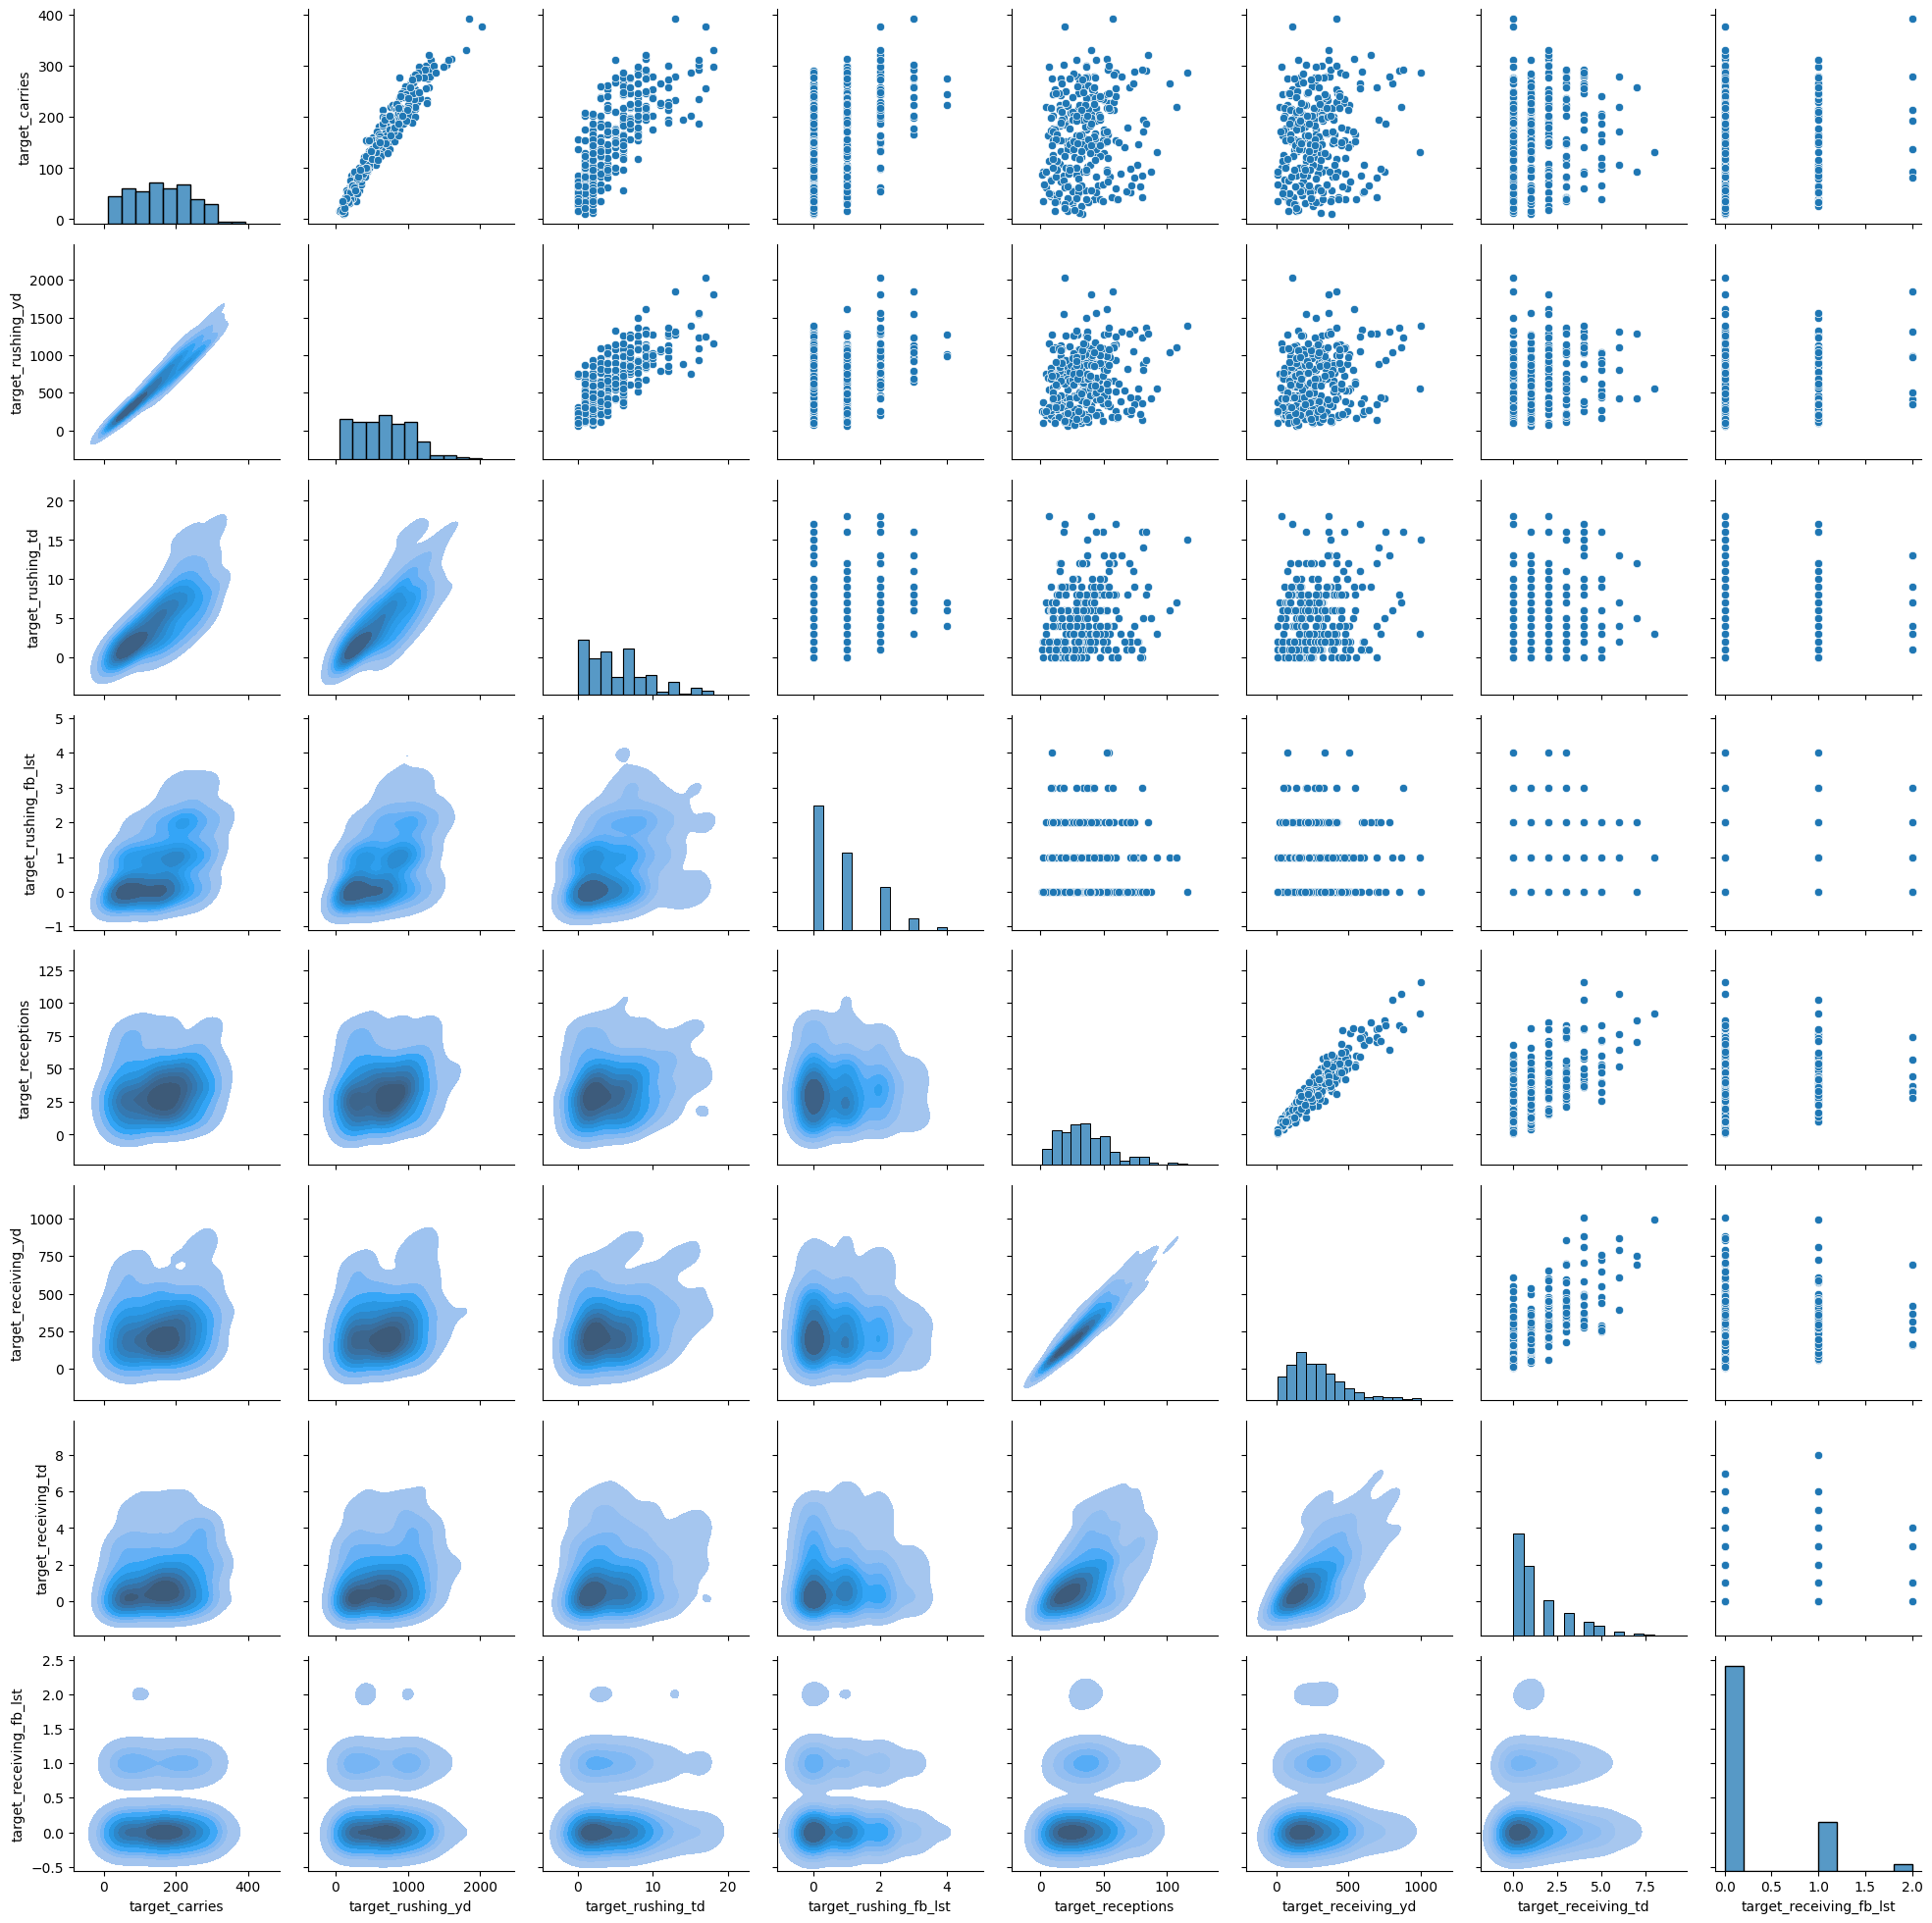

In [318]:
# Get Target Columns
g = sns.PairGrid(test_data)
# Map plots to the grid
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot)

plt.show();

### Define Variable Types

In [319]:
numeric_columns = ['games_played', 'seasons_played', 'career_carries', 
                    'career_carries_pg', 'career_rushing_yd', 'career_rushing_ypg', 
                    'career_rushing_td', 'career_rushing_td_pg', 'career_rushing_fd', 
                    'career_rushing_fd_pg', 'career_rushing_epa', 'career_rushing_epa_pg', 
                    'career_receptions', 'career_targets', 'career_target_share', 
                    'career_catch_rate', 'career_receptions_pg', 'career_receiving_yd', 
                    'career_receiving_ypg', 'career_receiving_td', 'career_receiving_td_pg', 
                    'career_receiving_fd', 'career_receiving_fd_pg', 'career_receiving_epa', 
                    'career_receiving_epa_pg', 'prev_season_games_played', 'prev_season_carries', 
                    'prev_season_carries_pg', 'prev_season_rushing_yd', 'prev_season_rushing_ypg', 
                    'prev_season_rushing_td', 'prev_season_rushing_td_pg', 'prev_season_rushing_fb', 
                    'prev_season_rushing_fb_pg', 'prev_season_rushing_fd', 'prev_season_rushing_fd_pg', 
                    'prev_season_rushing_epa', 'prev_season_rushing_epa_pg', 'prev_season_receptions', 
                    'prev_season_targets', 'prev_season_target_share', 'prev_season_catch_rate', 
                    'prev_season_receptions_pg', 'prev_season_receiving_yd', 'prev_season_receiving_ypg', 
                    'prev_season_receiving_td', 'prev_season_receiving_td_pg', 'prev_season_receiving_fd', 
                    'prev_season_receiving_fd_pg', 'prev_season_receiving_epa', 'prev_season_receiving_epa_pg']

#categorical_columns = ['target_season']

drop_columns = ['player_id', 'player_display_name', 'target_season']

assert(len(numeric_columns) + len(drop_columns) == len(X_train.columns))

## PCA Analysis

### Find Number of PCs

In [334]:
# Preprocess Data

# Create scaling object
scaler = StandardScaler()

# Fit scaling object
scaler.fit(modeling_data[numeric_columns])

# Create transformed data
scaled_modeling_data = pd.DataFrame(scaler.transform(modeling_data[numeric_columns]), columns=numeric_columns)

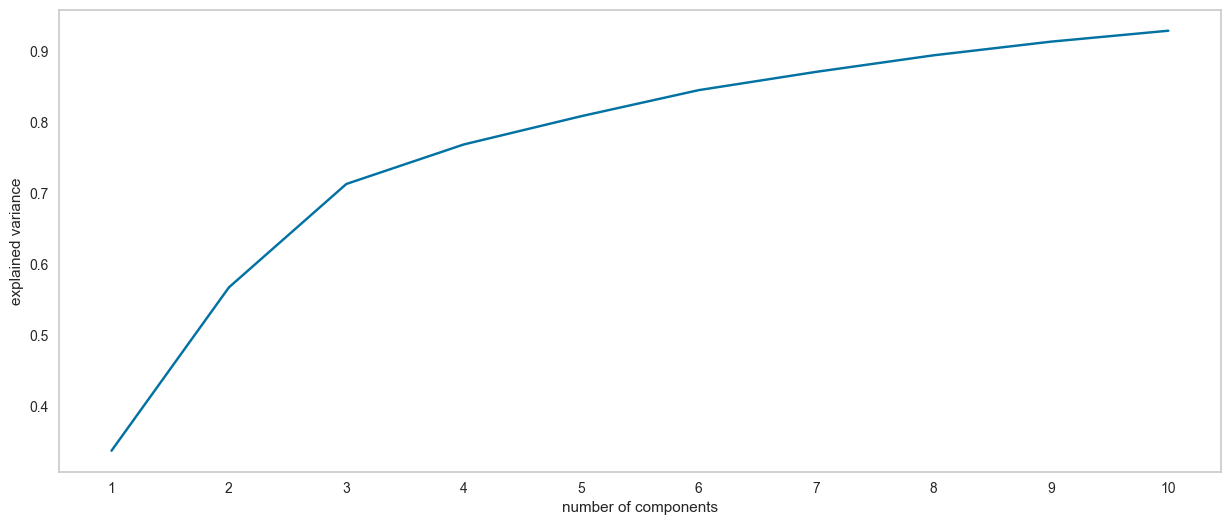

In [346]:
# Creating and fitting the model
pca = PCA(n_components=10, random_state=42).fit(scaled_modeling_data)

plt.figure(figsize=(15, 6))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, 11))
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.grid();

In [347]:
pca.explained_variance_ratio_.sum()

0.9291182635420303

### Summary

Ten PCA components explain ~93% of the explained variance in the data, so I will use 10 PCs in this analysis

In [348]:
n_pc = 10

### Define Pipeline

In [320]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_columns),
    (numeric_transformer, numeric_columns),
    #(categorical_transformer, categorical_columns),
)

### Define Target Datasets

In [321]:
# Rushing Carries
y_train_rushing_carries = y_train[['target_carries']]
y_test_rushing_carries = y_test[['target_carries']]

# Rushing Yards
y_train_rushing_yd = y_train[['target_rushing_yd']]
y_test_rushing_yd = y_test[['target_rushing_yd']]

# Rushing TD
y_train_rushing_td = y_train[['target_rushing_td']]
y_test_rushing_td = y_test[['target_rushing_td']]

# Rushing Fumbles
y_train_rushing_fb = y_train[['target_rushing_fb_lst']]
y_test_rushing_fb = y_test[['target_rushing_fb_lst']]

# Receptions
y_train_receptions = y_train[['target_receptions']]
y_test_receptions = y_test[['target_receptions']]

# Receiving Yards
y_train_receiving_yd = y_train[['target_receiving_yd']]
y_test_receptions_yd = y_test[['target_receiving_yd']]

# Receiving TD
y_train_receiving_td = y_train[['target_receiving_td']]
y_test_receptions_td = y_test[['target_receiving_td']]

# Receiving Fumbles
y_train_receiving_fb = y_train[['target_receiving_fb_lst']]
y_test_receptions_fb = y_test[['target_receiving_fb_lst']]

### Model Setup

1.  Ridge
2. Lasso
3. ElasticNet
4. DecisionTreeRegressor
5. SVR
6. RandomForestRegressor
7. GradientBoostingRegressor
8. AdaBoostRegressor

In [362]:
# Define Default Pipelines
pipe_R = make_pipeline(preprocessor, 
                       PCA(n_components=n_pc),
                       Ridge())
pipe_L = make_pipeline(preprocessor, 
                       PCA(n_components=n_pc),
                           Lasso())
pipe_EN = make_pipeline(preprocessor, 
                        PCA(n_components=n_pc),
                            ElasticNet())
pipe_DTR = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                         DecisionTreeRegressor())
pipe_SVR = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                             SVR())
pipe_RFR = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                         RandomForestRegressor())
pipe_GBR = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                         GradientBoostingRegressor())
pipe_ABR = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                         AdaBoostRegressor())

# Define Parameter Grids
R_param_grid = {
    'regressor__alpha': 10.0 ** np.arange(-6, 6, 1), 
    'regressor__fit_intercept': [True, False], 
    'regressor__solver': ['auto']
}

L_param_grid = {
    'regressor__alpha': 10.0 ** np.arange(-6, 6, 1), 
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter':  [10, 20, 30, 40, 50],
    'regressor__tol':  [1e-4, 1e-5, 1e-6]
}

EN_param_grid = {
    'regressor__alpha': 10.0 ** np.arange(-6, 6, 1),
    'regressor__l1_ratio': [0.2, 0.5, 0.8],
    'regressor__fit_intercept': [True, False], 
    'regressor__max_iter':  [1000, 5000, 10000],
    'regressor__tol':  [1e-4, 1e-5, 1e-6]
}

DTR_param_grid = {
    'regressor__max_features': [None, "sqrt", "log2"], 
    'regressor__max_depth': [None, 3, 5, 10], 
    'regressor__min_samples_split':  [2, 5, 10, 20], 
    'regressor__min_samples_leaf': [1, 3, 5, 10]
}

SVR_param_grid = {
    'regressor__C': [0.1, 1.0, 10.0], 
    'regressor__epsilon': [0.01, 0.1, 1.0], 
    'regressor__kernel':  ["linear", "poly", "rbf"], 
    'regressor__gamma': [0.01, 0.1, 1.0]
}

RFR_param_grid = {
    'regressor__n_estimators': [100, 200, 500], 
    'regressor__max_depth':  [None, 5, 10, 20], 
    'regressor__min_samples_split':  [2, 5, 10], 
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ["auto", "sqrt", "log2"],
    'regressor__random_state': [42]

}

GBR_param_grid = {
    'regressor__max_depth':  [None, 5, 10, 20], 
    'regressor__min_samples_split':  [2, 5, 10], 
    'regressor__min_samples_leaf': [1, 3, 5],
    #'regressor__max_features': ["auto", "sqrt", "log2"],
    'regressor__random_state': [42]
}

ABR_param_grid = {
    'regressor__n_estimators': [100, 200, 500], 
    'regressor__learning_rate': [100, 200, 500], 
    'regressor__loss':   ["linear", "square", "exponential"], 
    'regressor__estimator':  [RandomForestRegressor()], 
    'regressor__random_state': [42]
}

### Create RB Rushing Yards Model
#### Ridge Regression

In [370]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_R['pca']),
                         ('regressor', pipe_R['ridge'])])

# Create the GridSearchCV object
grid_search_R = GridSearchCV(opt_pipeline, R_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_R.fit(X_train, np.ravel(y_train_rushing_yd))

# Print the best parameters and the best score
print("Best parameters: ", grid_search_R.best_params_)
print("Best score: ", grid_search_R.best_score_)

# Define Winning Model
params_R = grid_search_R.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'regressor__alpha': 100.0, 'regressor__fit_intercept': True, 'regressor__solver': 'auto'}
Best score:  0.47145866418094007


#### Lasso Regression

In [374]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_L['pca']),
                         ('regressor', pipe_L['lasso'])])

# Create the GridSearchCV object
grid_search_L = GridSearchCV(opt_pipeline, L_param_grid, cv=5, n_jobs=-1, verbose=1);

# Fit the GridSearchCV object to the data
grid_search_L.fit(X_train, np.ravel(y_train_rushing_yd))

# Print the best parameters and the best score
print("Best parameters: ", grid_search_L.best_params_)
print("Best score: ", grid_search_L.best_score_)

# Define Winning Model
params_L = grid_search_L.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters:  {'regressor__alpha': 10.0, 'regressor__fit_intercept': True, 'regressor__max_iter': 10, 'regressor__tol': 0.0001}
Best score:  0.4734873962311685


#### Elastic Net Regression

In [375]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_EN['pca']),
                         ('regressor', pipe_EN['elasticnet'])])

# Create the GridSearchCV object
grid_search_EN = GridSearchCV(opt_pipeline, EN_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_EN.fit(X_train, np.ravel(y_train_rushing_yd))

# Print the best parameters and the best score
print("Best parameters: ", grid_search_EN.best_params_)
print("Best score: ", grid_search_EN.best_score_)

# Define Winning Model
params_EN = grid_search_EN.best_params_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters:  {'regressor__alpha': 1.0, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.5, 'regressor__max_iter': 1000, 'regressor__tol': 0.0001}
Best score:  0.47161644344108444


Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Best parameters:  {'classifier__alpha': 1.0, 'classifier__fit_intercept': True, 'classifier__l1_ratio': 0.2, 'classifier__max_iter': 1000, 'classifier__tol': 0.0001}


Best score:  0.3346292788018777

#### Decision Tree Regressor

#### SVR

#### Random Forest Regressor

#### Gradient Boosted Regressor

#### ADA Boost Regressor

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters:  {'classifier__base_estimator': DecisionTreeRegressor(), 'classifier__learning_rate': 500, 'classifier__loss': 'square', 'classifier__n_estimators': 200, 'classifier__random_state': 42}

Best score:  -0.6657064531111454

### Model Comparison

In [376]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [377]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [379]:
params_R

{'regressor__alpha': 100.0,
 'regressor__fit_intercept': True,
 'regressor__solver': 'auto'}

In [381]:
# Define Regression
R_pipe = make_pipeline(preprocessor,
                       PCA(n_components=n_pc),
                       Ridge(alpha = params_R['regressor__alpha'],
                             fit_intercept = params_R['regressor__fit_intercept'],
                             solver = params_R['regressor__solver']))

# Define Lasso
L_pipe = make_pipeline(preprocessor, 
                       PCA(n_components=n_pc),
                       Lasso(alpha = params_L['regressor__alpha'],
                             fit_intercept = params_L['regressor__fit_intercept'],
                             max_iter = params_L['regressor__max_iter'],
                             tol = params_L['regressor__tol']))

# Define Elastic Net
EN_pipe = make_pipeline(preprocessor, 
                        PCA(n_components=n_pc),
                        ElasticNet(alpha = params_EN['regressor__alpha'],
                                   fit_intercept = params_EN['regressor__fit_intercept'],
                                   max_iter = params_EN['regressor__max_iter'],
                                   tol = params_L['regressor__tol']))

# Define Decision Tree Regression
#DTR_pipe = make_pipeline(preprocessor, 
#                         PCA(n_components=n_pc,
#                         DecisionTreeRegressor(max_depth = params_DTR['classifier__max_depth'],
#                                               max_features = params_DTR['classifier__max_features'],
#                                               min_samples_leaf = params_DTR['classifier__min_samples_leaf'],
#                                               min_samples_split = params_DTR['classifier__min_samples_split']))

# Define SVR
#SVR_pipe = make_pipeline(preprocessor, 
#                         PCA(n_components=n_pc,
#                         SVR(C = params_SVR['classifier__C'],
#                             epsilon = params_SVR['classifier__epsilon'],
#                             gamma = params_SVR['classifier__gamma'],
#                             kernel = params_SVR['classifier__kernel']))

# Define RFR
#RFR_pipe = make_pipeline(preprocessor, 
#                         PCA(n_components=n_pc,
#                         RandomForestRegressor(max_depth = params_RFR['classifier__max_depth'],
#                                               max_features = params_RFR['classifier__max_features'],
#                                               min_samples_leaf = params_RFR['classifier__min_samples_leaf'],
#                                               min_samples_split = params_RFR['classifier__min_samples_split'],
#                                               n_estimators = params_RFR['classifier__n_estimators'],
#                                               random_state = params_RFR['classifier__random_state']))

# Define GBR
#GBR_pipe = make_pipeline(preprocessor,
#                         PCA(n_components=n_pc,
#                         GradientBoostingRegressor(max_depth = params_GBR['classifier__max_depth'],
#                                                   min_samples_leaf = params_GBR['classifier__min_samples_leaf'],
#                                                   min_samples_split = params_GBR['classifier__min_samples_split'],
#                                                   random_state = params_GBR['classifier__random_state']))

# Define ABR
#ABR_pipe = make_pipeline(preprocessor, 
#                         PCA(n_components=n_pc,
#                         AdaBoostRegressor(estimator = params_ABR['classifier__base_estimator'],
#                                           learning_rate = params_ABR['classifier__learning_rate'],
#                                           loss = params_ABR['classifier__loss'],
#                                           n_estimators = params_ABR['classifier__n_estimators'],
#                                           random_state = params_ABR['classifier__random_state']))


models = {
    "Ridge" : R_pipe,
    "Lasso" : L_pipe,
    "Elastic Net" : EN_pipe
#    "Decision Tree Regressor" : DTR_pipe,
#    "SVR" : SVR_pipe,
#    "Random Forest Regression" : RFR_pipe,
#    "Gradient Boosting Regressor" : GBR_pipe,
#    "Ada Boost Regressor" : ABR_pipe
}

In [382]:
results = {}

for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, np.ravel(y_train_rushing_yd), return_train_score=True, scoring=scoring_metrics
    )

pd.DataFrame(results)

,Ridge,Lasso,Elastic Net
fit_time,0.012 (+/- 0.001),0.011 (+/- 0.001),0.010 (+/- 0.000)
score_time,0.004 (+/- 0.000),0.004 (+/- 0.000),0.004 (+/- 0.000)
test_score,0.471 (+/- 0.109),0.473 (+/- 0.113),0.472 (+/- 0.109)


In [385]:
params_L

{'regressor__alpha': 10.0,
 'regressor__fit_intercept': True,
 'regressor__max_iter': 10,
 'regressor__tol': 0.0001}

### Winning Model: Lasso

Prameters:
- classifier__alpha: 10.0
- classifier__fit_intercept: True
- classifier__max_iter: 10
- classifier__tol: 0.0001}

Best Score: 0.473

## Fit the Winning Model

In [386]:
L_fit = pipe_L.fit(X_train, y_train_rushing_yd)

## Generate Test Predictions

In [387]:
L_predictions = L_fit.predict(X_test)

## Model Performance

In [388]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

def evaluate_model(y_true, y_pred):
    """
    Calculates various evaluation metrics for a binary classification problem.

    Parameters:
    - y_true (array-like): True labels
    - y_pred (array-like): Predicted labels

    Returns:
    - accuracy (float): Accuracy of the model
    - f1 (float): F1 score of the model
    - auc (float): AUC-ROC of the model
    - precision (float): precision of the model
    - recall (float): recall of the model
    """
    MSE = mean_squared_error(y_true, y_pred)
    MAP = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    
    print(f'MSE: {MSE:.2f}')
    print(f'MAP: {MAP:.2f}')
    print(f'R-squared: {R2:.2f}')
    
    return (MSE, MAP, R2)

In [390]:
model_performance = evaluate_model(y_test_rushing_yd, L_predictions)

MSE: 66094.57
MAP: 0.34
R-squared: 0.32


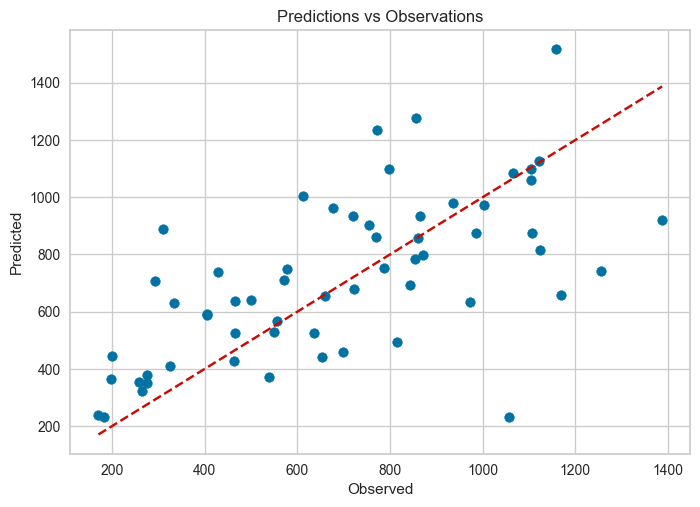

In [391]:
plt.scatter(y_test_rushing_yd.target_rushing_yd, L_predictions)
plt.plot([min(y_test_rushing_yd.target_rushing_yd), 
          max(y_test_rushing_yd.target_rushing_yd)], 
         [min(y_test_rushing_yd.target_rushing_yd), 
          max(y_test_rushing_yd.target_rushing_yd)], 'r--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Predictions vs Observations')
plt.show()